# Multi-layer Feed Forward Neural Network

In this exercise you will implement a multi-layer feed forward neural network also known as the perceptron. We will start with generating some synthetic data that cannot be classified with a linear classifier such as a perceptron or logistic regression.

It is **VERY** important that you implement this yourself without use of any libraries besides python numpy, matplotlib. You also may not copy paste code from somewhere else. I will give you steps to do. Those were designed to restrict your design a bit to help you along but also to make it harder to just use somebody else's solution. I have google too and you will get a $0$ if I find you copied code from elsewhere (I am looking at you Github). 

**YOU MUST IMPLEMENT MY FUNCTION STUBS**


We start with the usual suspect imports.

In [1]:
#Emmanuil Simkhayev
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
plt.style.use('ggplot')
%matplotlib inline
#The next cell may not be necessary. I am using it to get equation numbers.

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Generating XOR Data 

We are going to generate that like the famous XOR counterexample that cannot be classified using a linear classifier like the perceptron. Basically this will have 4 blobs. One in each quadrant and diagonal blobs will be in the same class. That way you can use a linear classifier to separate the blobs. This will motivate you building a multi-layer neural net to separate the blobs.

In [3]:
# Constants
DATA_SEED = 42
num_samples = 4000
XOR_means = np.array([[1,1],[1,-1],[-1,-1],[-1,1],])
XOR_stds = np.array([.2,0.2,.15,.4])
XOR = np.array([1,0,1,0])
np.random.seed(DATA_SEED)

In [4]:
# Make Fake data
model_index = np.random.randint(0,4,num_samples)
X_0 = np.array([XOR_means[ind]+XOR_stds[ind]*np.random.randn(len(XOR_means[ind])) for ind in model_index])
y_0 = np.array([XOR[ind] for ind in model_index])

In [5]:
# Get the max and min of the data
X_min, X_max = X_0.min(axis=0), X_0.max(axis=0)
# For visualiztion Give a margin so the data sits inside a box where the probability
# shows up
x_min, x_max = X_min[0] - .5, X_max[0] + .5
y_min, y_max = X_min[1] - .5, X_max[1] + .5

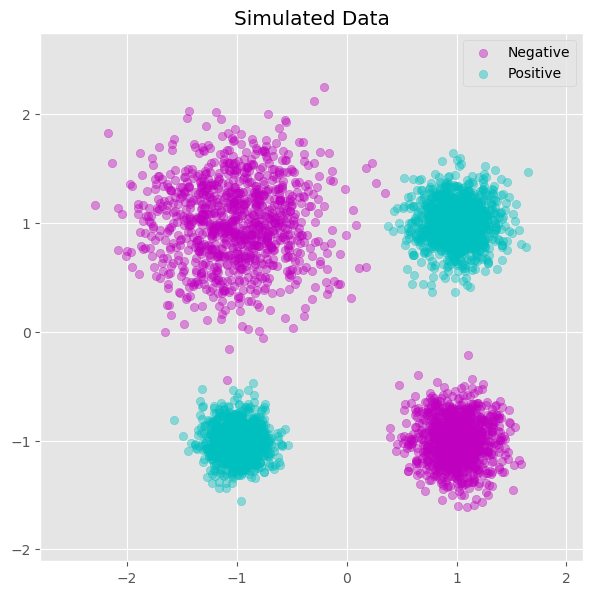

In [6]:
#Visualization configuration

# P are points the classifier thinks are postive
# N are points the classifier thinks are negative
# These are graphic styles
N_kwargs=dict(c='m',zorder=2,alpha=0.4,label="Negative")
P_kwargs=dict(c='c',zorder=5,alpha=0.4,label="Positive")


# Figure paremeters
# Used throughtout
fig_kwargs = dict(figsize=(7,7),dpi=100)
# Make the fig
fig, ax = plt.subplots(**fig_kwargs)
ax.set(xlim=(x_min,x_max), ylim=(y_min,y_max))
ax.margins(0.2)
ax.set_title("Simulated Data")
scats = [ax.scatter(X_0[y_0==0,0],X_0[y_0==0,1],**N_kwargs),
         ax.scatter(X_0[y_0==1,0],X_0[y_0==1,1],**P_kwargs)]
ax.legend(); # To suppress the print

## Multi-Layer Feed Forward Neural Network

In order to solve this using an neural network you are going to need to use multiple layers. I will set up some notation. Your networks should follow along, particularly because if you don't you will really be lost when you try to implement backpropagation.

I will be mostly using the notation in the video from the [3Blue1Brown Calc or Backprop video]( https://youtu.be/tIeHLnjs5U8).

### Notation

We consider a feed forward network with $M+1$ layers. The $0$th layer is the input layer and the $M$th layer is the output layer. The there are $n^{(L)}$ nodes in the $L$th layer. Each node produces an activation.

* The input matrix is $X$ with $N$ rows representing observations and $n^{(0)}$ columns representing features or inputs.

* The target vector is $y$ having $N$ rows representing the target labels for the $N$ observations.

* The layers $1 \leq L \leq M-1$ are called hidden layers.

* The $i$th activation in layer $L$ is written $a_i^{(L)}$

* The activation at the input layer are $a_i^{(0)}=x_i$ which are the inputs.
* To take into account bias terms, the $0$th activations $a_0^{(L)} = 1$ are all the constant $1$. These can be thought of a special nodes.
* We define weights going from the $k$th node in layer $L-1$ to $j$th node in the $L$th as $w_{j,k}^{(L)}$ where $1\leq k \leq n_{(L-1)}$, and $1\leq j \leq n_{(L)}$.
* We define bias weights $b_{j}$ feeding to the $j$th node in layer $L$,  and we write them as weights with index $0$, in other words $w_{j,0}=b_j$.
* Each pre-activations feeding into the activations are written $z_j^{(L)}$
* The pre-activations combine the activations of the previous layers linearly through the weights so 

\begin{equation}
z_j^{(L)} = \sum_{k=0}^{n^{(L)}} w_{j,k}^{(L)}a_k^{(L-1)}
\end{equation}

* The activations come from the pre-activation via an activation function $\varphi(z)$ so that $a_j^{(L)}=\varphi(z_j^{(L)})$ for $1\leq j\leq n_{(L)}$.
* In this neural network we will use the logistic sigmoid so that

\begin{equation}
\varphi(z) = \frac{1}{1+e^{-z}}
\end{equation}
* It is important to note there **is no** $z_0^{(L)}$.
* The cost function is: $C=C(a^{(M)},y)$
* We will use the cross-entropy cost function so that if the target label is $y$ which is $1$ or $0$ then the cost is 

\begin{equation}
C(a^{(M)},y) = -y \mbox{log}(a^{(M)}) - (1-y) \mbox{log}(1-a^{(M)})
\end{equation}

Note that if $y=1$ we only have the first term, and if $y=0$ only the second. Also note that when $y=1$ we would like $a^{(M)}$ to be close to $1$. If it is then $\mbox{log}(a^{(M)})$ will be close to $0$ and the cost will be very small. On the other hand if $a^{(M)}$ is close to $0$ that is a bad classification. In that case $-\mbox{log}(a^{(M)})$ will be a very large number indicating a high cost. Similarly if $y=0$ we get a very low cost if $a^{(M)}$ is close to 0, and a high cost if it is close to $1$.

### Vectorizing the Forward Feed

At each layer we have a weight matrix $W^{L}$ so that the first column $w_{\cdot,0}^{L}$ are the bias terms and the other weights $w_{j,k}^{L}$ are just the weights between network nodes. 

$$ 
\begin{bmatrix}
w_{1,0}^{(L)} & w_{1,1}^{(L)} & \cdots & w_{1,n^{(L-1)}}^{(L)}\\
            & \vdots & \\
w_{n^{(L)},0}^{(L)} & w_{1,1}^{(L)} & \cdots & w_{n^{(L)},n^{(L-1)}}^{(L)}
\end{bmatrix}
=
\begin{bmatrix}
b_{1}^{(L)} & w_{1,1}^{(L)} & \cdots & w_{1,n^{(L-1)}}^{(L)}\\
            & \vdots & \\
b_{n^{(L)}}^{(L)} & w_{n^{(L)},1}^{(L)} & \cdots & w_{n^{(L)},n^{(L-1)}}^{(L)}
\end{bmatrix}
$$


Since we are using the trick where we create "fake" nodes that input the number "1" so we can treat the bias the same as the other weights, lets lets write $\hat{X}$ for the input matrix $X$ which has an added column of "1" as first column (index $0$):

$$ 
\tilde{X} = 
\begin{bmatrix}
x_{1,0} & x_{1,1} & \cdots & x_{1,n^{(0)}}\\
            & \vdots & \\
x_{N,0} & x_{N,1} & \cdots & x_{N,n^{(0)}}
\end{bmatrix}
=
\begin{bmatrix}
1 & x_{1,1} & \cdots & x_{1,n^{(0)}}\\
            & \vdots & \\
1 & x_{N,1} & \cdots & x_{N,n^{(0)}}
\end{bmatrix}
$$

The activations at the $1$st hidden layer is a matrix where each row corresponds to an observation.

$$ 
A^{(1)}  = 
\begin{bmatrix}
a_{1,0} & a_{1,1} & \cdots & a_{1,n^{(1)}}\\
            & \vdots &\\
a_{N,0} & a_{N,1} & \cdots & a_{N,n^{(1)}} 
\end{bmatrix}
$$

So the relationship between inputs and the first activation is

$$ A^{(1)}  = \varphi(W^{(1)}\tilde{X}^T)$$

where $\varphi$ is the first activation applied to all the inputs. This is applied element wise. After that we have:

$$ A^{(L)}  = \varphi(W^{(L)}(A^{(L-1)})^T)$$

connecting the $L-1$th layer to the $L$th layer. Note that $ A^{(M)}$ is the output of the feed forward network. That is the prediction of the network which we compare with $y$.

In [220]:
# Initialize the meta-paramters here.
# This should hold variables that specify the number of nodes in
# each layer including the input, hidden and output layers.
# first is number of inputs 
# next ones are hidden layers
# ouput layer always has one in our example
num_nodes_in_layers_0 = [2,5,4]
# [2,3,4] did okay but [2,5,4] was a little bit better. 

In [224]:
# initialize weights to random numbers (randn) here
# Keep in mind that the number of weights going from one layer to
# the next. 
# This should return a list of numpy arrays. 
# Each is numpy.array of weights with L rows and L-1 columns
def init_weights(num_nodes_in_layers, 
                 data_seed=DATA_SEED):
    np.random.seed(data_seed)
    # Fill this in
        
    layer_weights = []
    
    #sample weights and store in list.
    for i in range(len(num_nodes_in_layers)-1) :
        layer_weights.append(np.random.randn(num_nodes_in_layers[i+1], num_nodes_in_layers[i] + 1))
    
    #last np array of weights    
    layer_weights.append(np.random.randn(1, num_nodes_in_layers[-1]  + 1))
    return layer_weights

# if we have num_nodes_in_layers_0 = [2,3,4]
layer_weights_0 = init_weights(num_nodes_in_layers_0)
# print(layer_weights_0)
# then this:
for weights in layer_weights_0:
    print(weights.shape, end='') 
# should print
# (3, 3)(4, 4)(1, 5)
# and the numpy arrays should be filled with numbers from between 0 and 1

(5, 3)(4, 6)(1, 5)

In [200]:
# Here is the sigmoid
def sigmoid(z):
#     print("in sigmoid shape", ((1 + np.exp(-z))**(-1)).shape)
    return (1 + np.exp(-z))**(-1)

In [201]:
# This should be a function that 
# compute hidden layer 1 activation (input activations are just inputs)
# note you need to tread the index 0 weights, the bias's differently.
# typicaly you feed in inputs but add a "1" to the beginning of the
# input so the first weight just gets added

def compute_activations(inputs, weights):
    inputs=np.atleast_2d(inputs)
    inputsSz = inputs.shape
    # Need to extend the matrix with one column of ones for the
    # bias term
    # Make a matrix with one more column and fill with ones
    
    # fill this in
    
    # adding a column of ones to the inputs matrix 
    # create a matrix of desired shape.
    inputs_hat = np.ones((inputs.shape[0], inputs.shape[1]+1))

    # assign input values in columns after the first column.  
    inputs_hat[:, 1:] = inputs
    
    # compute z  
    z = weights.dot(inputs_hat.T)
    
    return sigmoid(z)

In [202]:
# compute feed forward (predict)
def predict(inputs,layer_weights):
    activations = [inputs]
#     #feed forward
    
    # Fill this in
    # To keep dimensionality consistent, the input layet is computed separate, as the input does not need to be transposed like
    # other activations.
    activations.append(compute_activations(activations[0], layer_weights[0]))
    
    for i in range(1,len(layer_weights)):
        
        activations.append(compute_activations(activations[i].transpose(), 
                                               layer_weights[i]))
    
    #reshape the final activation layer to (num_samples,)
    activations[-1] = activations[-1].reshape(inputs.shape[0],)
    return activations

In [203]:
# compute loss
def cross_entropy_loss(y,y_pred):
    """Loss based on negative log-likelihood of the data.
    Target values passed in first.
    """
    loss = np.zeros(y.shape)
    loss[y==1]= - np.log(y_pred[y==1])
    loss[y!=1]= - np.log(1-y_pred[y!=1])
    return loss.mean()

In [204]:
# In order to visualize the classifier, we will use the matlab countourf
# function to create a heat map that shows the probability in-between the
# data points. This means we need to make a grid of samples to test the
# probability. Since this classifier is we don't need alot of points
h = .2  # step size in the mesh
# This makes 2-D grids of x and respectively y coorindates
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#This is where we set the color map
#for the heat map. Currently set red to blue
cm = plt.cm.RdBu
# Some colormap normalizations
bounds = np.arange(0,11)*0.1
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
shrink = 0.8


# Because we call this many times and repeatedly in the
# animation code below, it is best to set all the color
# and visual properties for the data points

# FN are points the classifier thinks are negative but are positive
FN_kwargs = dict(animated=True,               
                s=50,
                edgecolors='m',
                linewidths=2,
                facecolors='none',
                marker='o',
                zorder=20,
                alpha=0.4,
                label='False Negative')
# FN are points the classifier thinks are positive but are negative
FP_kwargs = dict(animated=True,               
                s=50,
                edgecolors='c',
                linewidths=2,
                facecolors='none',
                marker='o',
                zorder=10,
                alpha=0.4,
                label='False Positive')

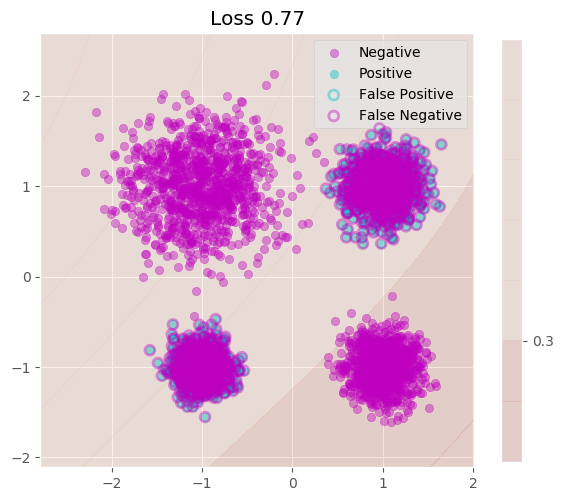

In [205]:
# visualize function
# This is an all-in-one function that goes from Data to visualization of
# prediction. Note you need to give it the weights and bias.

def show_classification(X,y,layer_weights):
    y_pred = predict(X, layer_weights)[-1]
    # added another [-1] indexing to predict() because it would not retrieve
    # the required dimension.
#     print("y_pred ",y_pred.shape)
#     print([a.shape for a in y_pred])
    y_pred_label = y_pred> 0.5
    loss = cross_entropy_loss(y,y_pred)
    fig, ax = plt.subplots(**fig_kwargs)
    ax.set_title("Loss {:03.2f}".format(loss))
    Z = predict(np.c_[xx.ravel(),yy.ravel()], layer_weights)[-1]
    Z = Z.reshape(xx.shape)
    pcm = ax.contourf(xx,yy,Z,cmap=cm, alpha=.2, norm=norm)
    ax.scatter(X[y==0,0],X[y==0,1],**N_kwargs)
    ax.scatter(X[y==1,0],X[y==1,1],**P_kwargs)
    ax.scatter(X[np.logical_and(y_pred_label==1, y == 0),0],
               X[np.logical_and(y_pred_label==1, y == 0),1],
               **FP_kwargs)
    ax.scatter(X[np.logical_and(y_pred_label==0, y == 1),0],
               X[np.logical_and(y_pred_label==0, y == 1),1],
               **FN_kwargs)
    ax.legend()
    ax.set_aspect('equal')
    fig.colorbar(pcm, ax=ax,ticks=bounds,shrink=shrink)
    plt.show()
    return fig, ax

# Lets see an example with the random weights we choose. 
_ = show_classification(X_0,y_0,layer_weights_0)

# Backpropagation

We will know review backpropagation for the special case where there is a single output node. We are assuming we are doing classification and thus our cost function is cross entropy. 


In order to compute the gradient, we need to compute for each weight $w_{j,k}^{(L)}$ we need to compute the partial derivative $\frac{\partial C}{\partial w_{j,k}^{(L)}}$. We can do this via the chain rule:

\begin{equation}
\frac{\partial C}{\partial w_{j,k}^{(L)}} = \frac{\partial z_{j}^{(L)}}{\partial w_{j,k}^{(L)}} \frac{\partial C}{\partial z_{j}^{(L)}}
\end{equation}

Now the first term that multiplies this is the outputs/activations of the previous layer:

$$ \frac{\partial z_{j}^{(L)}}{\partial w_{j,k}^{(L)}} = a_k^{(L-1)}$$

We can expand the last factor of the partial above Equation (4) as

$$ \frac{\partial C}{\partial z_{j}^{(L)}} =  \frac{d a_{j}^{(L)}}{d z_{j}^{(L)}} \frac{\partial C}{\partial a_{j}^{(L)}}. $$

To expand the factor $d a_{j}^{(L)}/d z_{j}^{(L)}$ we note that this is just the derivative of the logistic function. The derivative of the logistic function $\varphi (z) = 1/(1+e^{-z})$ is 

$${\displaystyle {\frac {d\varphi }{dz}}(z)=\varphi (z)(1-\varphi (z))}$$.

If we substitute in $z_{j}^{(L)}$ and recall that $\varphi(z_{j}^{(L)}) = a_{j}^{(L)}$ we get 

$$\frac {d a_{j}^{(L)}}{dz_{j}^{(L)}}= a_{j}^{(L)}(1-a_{j}^{(L)})$$

It will turn out important to give $\frac{\partial C}{\partial z_{j}^{(L)}}$ a name so we will write it $\delta_j^{(L)}$. So now
$$
\delta_j^{(L)} = \frac{\partial C}{\partial z_{j}^{(L)}} = a_{j}^{(L)}(1-a_{j}^{(L)}) \frac{\partial C}{\partial a_{j}^{(L)}}
$$

and the component of the gradient is now just:

\begin{equation}
\frac{\partial C}{\partial w_{jk}^{(L)}} =  a_k^{(L-1)}\delta_j^{(L)}
\end{equation}

This equation is super important so please remember it. It says that the gradient at the layer $L$ is just each of the activations at the $L-1$ times $\delta_j^{(L)}$. In order to compute $\delta_j^{(L)}$ we still need to compute $\partial C/\partial a_{j}^{(L)}$.

### Cross-entropy (cost functions) 

Recall the cross entropy is:

$$ C(a,y) = - y \mbox{log}(a) -  (1-y) \mbox{log}(1-a)$$

The derivative of the cross entropy:

$$ \frac{\partial C}{\partial a}(a,y) = -(y/a) - ((1-y)/(1-a))
= - (y(1-a)- a (1-y))/a(1-a)$$
$$  = - (y-y a- a + y a))/a(1-a) = (a-y)/a(1-a)$$.

Now we can compute $\delta_j^{(M)}$. At the last layer in our case $j$ drops out so $\delta_j^{(M)}=\delta^{(M)}.$  Combining the above equation for $\partial C/\partial a^{(M)}$ and the formula for $\delta^{(M)}$ we get

$$ \delta^{(M)}=  \left( a^{(M)}(1-a^{(M)})\right) (a^{(M)}-y)/a^{(M)}(1-a^{(M)})$$
$$= (a^{(M)}-y)$$

Since $a^{(M)}$ is the prediction of the system and $y$ is the actual value the equation $\delta^{(M)}= (a^{(M)}-y)$ means we can interpret $\delta^{(M)}$ as the *error*. Since there is no $j$ in the last node, we finally get the gradient at component $1\leq k$  as 

$$\frac{\partial C}{\partial w_{k}^{(M)}} = a_k^{(L-1)}\delta^{(M)}
= a_k^{(M-1)}(a^{(M)}-y).$$

We interpret this to mean that at each observation we compute the error and then multiply by the one step back activations. Now keep in mind that one of the activations in each layer (we can take the zeroth one) is just the number "1" to account for the bias. In other words in the notation we have here $w_0^{(L)}$ is really $b^{(L)}$. Because the activation associated with $b^{(L)}$ is the constant $1$ then for that $w_{k}^{(L)}$

$$\frac{\partial C}{\partial b^{(M)}} = \delta^{(M)}$$.

Make sure you don't forget the $w_{0}^{(L)}$ is really a $b$. That one just gets the error as the weight.

## Vectorized version

Keep in mind that ${\delta}^{(M)}$ should be a column vector with $N$ rows (one for each observation), and the entries are the errors. We can now consider the matrix of activations $A^{(M-1)}$ which again has $N$ rows, where we have extended this so that the first column is all ones, and the other $n^{(M-1)}$ columns correspond to the nodes in layer $N-1$. The gradient is now just $(1/N)(A^{(M-1)})^T \delta^{(M)}$. Note this is the same size as $W^{(M)}$.


In [193]:
def delta_final(pred_y, y):
#Delta at the layer (L)    
    return pred_y - y

# compute gradient at layer
def grad_layer(activations, delta):
    # Fill this in
    
    #need to add a bais in activations for the bais in the weights
    activations_b = np.ones((activations.shape[0], activations.shape[1]+1))
    activations_b[:, 1:] =activations
    #Compute Gradient
    gradient = activations_b.T.dot(delta)
    
    #number of samples to dive the gradient by
    N = activations_b.shape[0]
    
    gradient = gradient/N
    return gradient 


## Next level backprop

We are going to compute how to go back one step from layer $L$ to layer $L-1$ and compute the gradient for $W^{(L)}$.
In order to go one more layer back, lets recall what we want to compute is
$\frac{\partial C}{\partial w_{j,k}^{(L-1)}}$ for all the $j$ and $k$. Unlike in the previous case of the output layer where we only had one "$j$", now we have many. According to what we found above, the gradient is just the  activation of one level times the backpropagated error. In other words:


$$\frac{\partial C}{\partial w_{j,k}^{(L-1)}} =  a_{k}^{(L-2)} \delta_{j}^{(L-1)}$$

The key thing we need to figure out is how to compute $\delta_{j}^{(L-1)}$ in terms of that layer and layers higher up. Recall that $\delta_{j}^{(L-1)} = \frac{\partial C}{\partial z_{j}^{(L-1)}}$. 

$$\delta_{j}^{(L-1)} = \frac{\partial C}{\partial z_{j}^{(L-1)}} =   \frac{d a_{j}^{(L-1)}}{d z_{j}^{(L-1)}} \frac{\partial C}{\partial a_{j}^{(L-1)}}$$

looking above and changing $L$ to $L-1$ we get  $da_{j}^{(L-1)}/dz_{j}^{(L-1)} = \varphi ' ( z_{j}^{(L-1)})$ and then we can substitute in and get

$$\delta_{j}^{(L-1)} = a_{j}^{(L-1)}(1-a_{j}^{(L-1)}) \frac{\partial C}{\partial a_{j}^{(L-1)}}$$

To understand $\frac{\partial C}{\partial a_{j}^{(L-1)}}$ we need to consider that variations in $a_{j}^{(L-1)}$ (in the $L-1$ layer) could contribute to *all* the nodes in the next layer $L$. We need to sum each of these contributions over all the $n^{(L-1)}$ nodes in the next layer to write in terms of the next layer. Again we can expand the sum of the terms as 

$$\frac{\partial C}{\partial a_{j}^{(L-1)}} =  \sum_{i=1}^{n_L} \frac{\partial z_{i}^{(L)}}{\partial a_{j}^{(L-1)}} \frac{\partial C}{\partial z_{i}^{(L)}}$$

We note that  $\delta_{i}^{(L)} = \partial C/\partial z_{i}^{(L)}$ and since $z_i^{(L)} = \sum_{j=0}^{n^{(L)}} w_{i,j}^{(L)}a_j^{(L-1)}$ it follows that

$$\frac{\partial C}{\partial a_{j}^{(L-1)}} =  \sum_{i=1}^{n_L} w_{i,j}^{(L)} \delta_{i}^{(L)}$$

Putting this, for $j\geq 1$ together we get 

$$ \delta_{j}^{(L-1)} = a_{j}^{(L-1)}(1-a_{j}^{(L-1)}) \sum_{i=1}^{n_L} w_{i,j}^{(L)} \delta_{i}^{(L)}$$

This allows us to backpropagate $\delta_{j}^{(L-1)}$ which is needed for the gradient.

### Vectorized version

Keep in mind that the backpropaged $delta^{(L-1)}$ will be a matrix of $N$ rows and  $n^{(L-1)}$ columns. Let $\check{W}^{(L)}$ be all the weights $w_{i,j}^{(L)}$ with $j \geq 1$. In other words we omit the bias weights for backpropagating $\delta$. Thus $\check{W}^{(L)}$ has $n^{(L)}$ columns and $n^{(L-1)}$ rows.

$$ \delta^{(L-1)} = (A^{(L-1)}*(1-A^{(L-1)})*(\check{W}^{(L)})^T (\delta^{(L)})^T)^T $$

where the "$*$" is component-wise multiplication. Thus all that mess above yields simple little equation. Note that the result is a matrix with $N$ rows and $n^{(L-1)}$ columns. The function above for the gradient should work with these deltas as well.

In [196]:
# Compute backpropagated deltas
# This function must take the delta in layer L along with activations 
# in layer L-1 and the weights W^(L) and returns the delta for layer L-1

def backpropagate_delta(delta_previous,activations,weights):
    # Fill this in
    # I am splitting the backpropagated delta in to two components, then 
    # will multiply them.
    
    # First component: Signmoid Prime
    sigmoid_prime = np.multiply(sigmoid(activations), 
                                (1 - sigmoid(activations)))
    # second component multiplying delta previous and weights
    weights_delta = np.dot(delta_previous, weights)
    
    # multiply two components to get backpropagated delta.
    backpropagated_delta = np.multiply(sigmoid_prime, weights_delta.T) 

    return backpropagated_delta



In [215]:
# This function takes all the y labels, all the layer weights and all the 
# activations (all layers) and returns a list of deltas starting with the 
# delta in the first hidden layer to the output layer delta

def backprop_deltas(y,activations,layer_weights):
    deltas=[]
    # Fill this in
    # backpropagation - iterate over layer weights and activations to compute all
    # deltas
    
    # The first or delta at layer L is computed using delta_final (the cost).

    delta_at_layer_L = delta_final(activations[-1].reshape(1,-1), y)
    deltas.append(delta_at_layer_L)
    
    #rename for consistency in next step.
    delta_prev = delta_at_layer_L

    #compute backpropagated deltas at each layer 
    for i in range(len(layer_weights)-1):
        delta_prev = backpropagate_delta(delta_prev.T, activations[-1 - (i+1)], 
                                         layer_weights[-1 - i][:,1:])
        deltas.append(delta_prev.T)
    
    #Flip np array since they were done backwards.
    deltas = np.flip(deltas, axis = 0)
    
    #after flipping, reshape the delta at layer L (4000,1) to (4000,)
    deltas[-1] = delta_at_layer_L[-1]
    
    return deltas

# Now that we have all the deltas we can compute all the gradient. 
#This is just a matter of applying grad_layer to each delta

def compute_gradient(activations,deltas):
    # Fill this in
    gradient = []    
    #do the operation for the last delta first. reshape delta to (m, 1)

    
    # the dimension of activation[0] (also the original inputs) is not consistent
    # with all other activations.
    # so I will compute that one separately.
    
    first_gradient = grad_layer(activations[0], deltas[0])
    gradient.append(first_gradient.T)
    
    for i in range(1,len(activations)-2):
        #compute gradient at layer
        g = grad_layer(activations[i].T, deltas[i])
        gradient.append(g.T)
        
    #Last gradient computed separately due to dimensionality
    grad = grad_layer(activations[-2].T, deltas[-1].reshape(-1,1))
    gradient.append(grad.T)
    
    return gradient

# The result of running these lines 
activations_0 = predict(X_0, layer_weights_0)
# print("activations: ", [a.shape for a in activations_0])
# print(layer_weights_0)
deltas_0 = backprop_deltas(y_0,activations_0,layer_weights_0)
# print(deltas_0)
print([d.shape for d in deltas_0])
gradient_0 = compute_gradient(activations_0,deltas_0)
for grad, weights in zip(gradient_0, layer_weights_0):
    print(grad.shape, weights.shape, end='')
# should give you    
#[(4000, 3), (4000, 4), (4000,)]
#(3, 3) (3, 3)(4, 4) (4, 4)(1, 5) (1, 5)
# assuming you had network structure 
# num_nodes_in_layers_0 = [2,3,4]

[(4000, 3), (4000, 4), (4000,)]
(3, 3) (3, 3)(4, 4) (4, 4)(1, 5) (1, 5)

In [216]:
# This code is crucial for checking your gradients
# This adds the abount h to the j,k th weights in the lth layer (that's a small L not a 1)
def add_h_to_wjkl(h,j,k,l,layer_weights):
    new_layer_weights = [np.array(weights) for weights in layer_weights]
    new_layer_weights[l][j,k] = new_layer_weights[l][j,k]+h
    return new_layer_weights

# This checks your gradients
# if you tweak a weight a tiny bit (h0)
# compute the cost and devide by the tweak ... thats the numerical
# derivative. That should be very close to what we computed
# via back propagation
def numerical_check(X,y, layer_weights,h0 = 0.00001):
    activations = predict(X, layer_weights)
    deltas = backprop_deltas(y,activations_0,layer_weights)
    gradients = compute_gradient(activations,deltas)
    for L in range(len(layer_weights)):
        for I in range(layer_weights[L].shape[0]):
            for J in range(layer_weights[L].shape[1]):
                #Check numerical gradients
                layer_weights_h = add_h_to_wjkl(h0,I,J,L,layer_weights)
                activations_h = predict(X, layer_weights_h)
#                 print("loss activations",activations[-1].shape)
                loss_0 = cross_entropy_loss(y,activations[-1])
#                 print("loss_0", loss_0)
                loss_h = cross_entropy_loss(y,activations_h[-1])
#                 print("loss_h", loss_h)
#                 ("grad[{}][{},{}]: {}".format(L,I,J,gradients[L][I,J])
                print("grad[{}][{},{}]: {}".format(L,I,J,gradients[L][I,J]),
                    "loss_h-loss_0/h0: {}".format((loss_h-loss_0)/h0))


numerical_check(X_0,y_0,layer_weights_0)

# should print out lines like
# grad[0][0,0]: -0.011482479385835609 loss_h-loss_0/h0: -0.011482462025647065
# grad[0][0,1]: 0.0025212818012110565 loss_h-loss_0/h0: 0.0025212984589018106
# grad[0][0,2]: 0.0002303140760470007 loss_h-loss_0/h0: 0.00023033093210500508
# ....
# grad[2][0,4]: -0.026259720651285165 loss_h-loss_0/h0: -0.026259697794017708
# and if you implemented correction your numbers should match?

grad[0][0,0]: -0.003674582534512085 loss_h-loss_0/h0: -0.011482462014544835
grad[0][0,1]: -0.00021793324973513184 loss_h-loss_0/h0: 0.0025212984589018106
grad[0][0,2]: 0.00017971733683535 loss_h-loss_0/h0: 0.00023033093210500508
grad[0][1,0]: -0.014964156195013322 loss_h-loss_0/h0: -0.011501089425269838
grad[0][1,1]: -0.002892817830261484 loss_h-loss_0/h0: -0.00719491363154745
grad[0][1,2]: -0.000727135311735002 loss_h-loss_0/h0: -0.0063501427782775
grad[0][2,0]: 0.012674106575662097 loss_h-loss_0/h0: 0.007322765027684141
grad[0][2,1]: 0.0023053089945575165 loss_h-loss_0/h0: 0.0016937301783315204
grad[0][2,2]: -0.0011833989691200167 loss_h-loss_0/h0: -0.0058137380576361855
grad[1][0,0]: 0.04995297058557327 loss_h-loss_0/h0: 0.05352091870802766
grad[1][0,1]: 0.030967682851373635 loss_h-loss_0/h0: 0.033209382988008684
grad[1][0,2]: 0.03981141272939791 loss_h-loss_0/h0: 0.04266202799918516
grad[1][0,3]: 0.044580471362222526 loss_h-loss_0/h0: 0.0476943878391367
grad[1][1,0]: -0.01745003234

In [217]:
# update weights
# This should return new weights where you updated the weights by subtracting
# the gradient times the learning rate
def update_weights(layer_weights,gradients, learning_rate=0.01):
    # Fill this in
    updated_weights = []
    for i in range(len(layer_weights)):
        #Not sure if there should be a stopping condition.
        updated_weights.append(layer_weights[i] - (gradients[i]*learning_rate))
        
    return updated_weights

In [225]:
# This function creates a list which starts with the passed in 
# layer_weights and keeps appending the updated weights
# as it trains for visualization
# this function implements batch gradient decent
def train_weights(X,y,layer_weights, epochs=1000, batch_size=100,learning_rate=0.01):
    training_sequence = [layer_weights]
    for iteration in range(epochs):
        for row_ind in range(1,X.shape[0],batch_size):
            # Fill this in
            #update batches by adjusting slices each iteration
            X_batch = X[row_ind:row_ind+batch_size]
            y_batch = y[row_ind:row_ind+batch_size]
            
            #Go through the steps of computing activations, deltas, and gradients.
            activations = predict(X_batch,training_sequence[-1])
            deltas = backprop_deltas(y_batch, activations , training_sequence[-1])
            gradients = compute_gradient(activations, deltas)
            #append the updated weights to training_sequence. 
            training_sequence.append(update_weights(training_sequence[-1],gradients, learning_rate))
        activations_T = predict(X, training_sequence[-1])
        loss_T = cross_entropy_loss(y,activations_T[-1])
#         print("Total Loss: {}".format(loss_T))

    return training_sequence

training_kwargs = dict(learning_rate=2.0,epochs=14244, batch_size=500)
training_sequence_0 = train_weights(X_0,y_0,layer_weights_0,**training_kwargs)

new_layer_weights_0 = training_sequence_0[-1]

print("len(training_sequence_0) = ",len(training_sequence_0))

C:\Users\Esimk_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


len(training_sequence_0) =  113953


C:\Users\Esimk_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


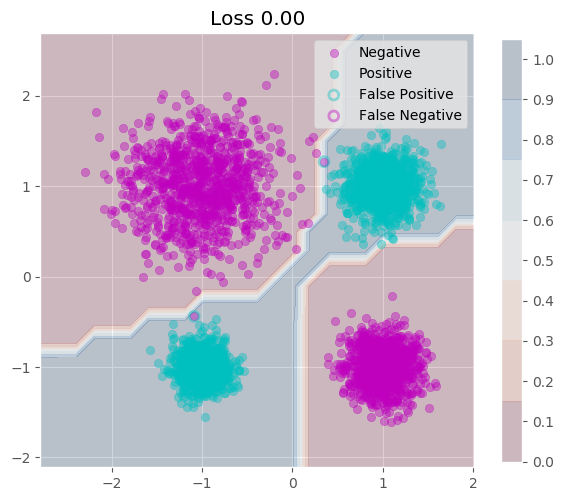

In [226]:
# visualize update
_ = show_classification(X_0,y_0,new_layer_weights_0)

In [227]:
def getGD_data(X,y,xx,yy, training_sequence):
    losses, FN_series, FP_series, Zseq = [],[],[],[]
    for weights in training_sequence:
        activations = predict(X, weights)
        y_pred_label = activations[-1]
        losses.append(cross_entropy_loss(y,y_pred_label))
        FN_series.append(X[np.logical_and(y_pred_label==0, y == 1),:])
        FP_series.append(X[np.logical_and(y_pred_label==1, y == 0),:])
        Z = predict(np.c_[xx.ravel(),yy.ravel()], weights)[-1]
        Z = Z.reshape(xx.shape)
        Zseq.append(Z)
    return losses, FN_series, FP_series, Zseq

# Movie will be too long if we have too many frames. Just taking the last 10
GD_data = getGD_data(X_0,y_0,xx,yy, training_sequence_0[::400])
len(GD_data[0])

C:\Users\Esimk_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


285

In [228]:
%%capture
def animate_opmimization(data, N_series, P_series):
    losses, FN_series, FP_series, Zseq = data
    vga = (640,460)
    ani_fig_kwargs = fig_kwargs
    ani_fig_kwargs['dpi']=100
    ani_fig_kwargs['figsize']= (vga[0]/ani_fig_kwargs['dpi'], vga[1]/ani_fig_kwargs['dpi'])
    fig, axs = None, None
    fig, axs = plt.subplots(nrows=1, ncols=2, **ani_fig_kwargs)
    heat_map_kwargs = dict(cmap=cm, alpha=.2,zorder=1,norm=norm, vmin=0, vmax=1.0)
    zz0=np.zeros(xx.shape)
    zz0[0][0]=1.0
    pcm = axs[0].contourf(xx,yy,zz0, **heat_map_kwargs)
    fig.colorbar(pcm, ax=axs[0],ticks=bounds,shrink=shrink)

    def init_animate():
        P_scatter = axs[0].scatter([], [], **P_kwargs)
        N_scatter = axs[0].scatter([], [], **N_kwargs)
        FN_scatter = axs[0].scatter([], [], **FN_kwargs)
        FP_scatter = axs[0].scatter([], [], **FP_kwargs)


    def animate(i):
        axs[0].cla()
        axs[1].cla()
        axs[0].axis([X_min[0],X_max[0],X_min[1],X_max[1]])
        axs[1].axis([1,len(losses),min(losses),max(losses)])
        axs[0].set_aspect('equal')
        axs[1].set_aspect(len(losses)/(max(losses)-min(losses)))
        axs[1].set_title("Training Error")
        axs[1].set_xlabel("Iteration")
        axs[0].contourf(xx,yy,Zseq[i],**heat_map_kwargs)
        axs[0].scatter(N_series[:,0],N_series[:,1],**N_kwargs)
        axs[0].scatter(P_series[:,0],P_series[:,1],**P_kwargs)
        axs[0].scatter(FN_series[i][:,0],FN_series[i][:,1],**FN_kwargs)
        axs[0].scatter(FP_series[i][:,0],FP_series[i][:,1],**FP_kwargs)
        axs[0].set_title("Loss {:03.2f}".format(losses[i]))
        axs[1].plot(range(i),losses[:i],'k')
    return fig, init_animate, animate

GD_fig, GD_init_animate, GD_animate = animate_opmimization(GD_data,X_0[y_0==0,:],X_0[y_0==1,:])

In [229]:
GD_ani = FuncAnimation(GD_fig,
                    GD_animate,
                    init_func=GD_init_animate,
                    frames=len(GD_data[0]))
GD_ani.save('MLPBatchSGD.mov')
GD_ani.save('MLPBatchSGD.mp4', fps=20, writer="ffmpeg", codec="libx264")

In [230]:
from IPython.display import HTML
VIDEO_TAG = """<video controls>
 <source src="{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""
video_tag = VIDEO_TAG.format('MLPBatchSGD.mp4')
HTML(video_tag)